# Project : Walmart Sales in Stormy Weather
---

## 1. Data Introduce
### 1.1 Purpose : Predict how sales of weather-sensitive products are affected by snow and rain
    

### 1.2 Data set:
   > - Train Data : 4617600 rows, 4 columns

   > - Test Data  : 526917 rows, 3 columns

   > - Weather Data : 20517 rows, 20 columns
   
   > - Key Data : 45 rows, 2 columns
   
   > - [링크 : Walmart Recruiting II: Sales in Stormy Weather](https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather)

### 1.3 Evaluation
   > - Root Mean Squared Logarithmic Error (RMSLE)  

$$
RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$


In [3]:
# Import libraries
'''
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
'''
from datetime import datetime

# Pretty display for notebooks
'''
%matplotlib inline
'''

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("../asset/train.csv")
test = pd.read_csv("../asset/test.csv")
weather = pd.read_csv("../asset/weather.csv")
key = pd.read_csv("../asset/key.csv")
submission = pd.read_csv("../asset/sampleSubmission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("weather  data : ", weather.shape)
print("key  data : ", key.shape)
print("submission  data : ", submission.shape)

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_test = test.copy
df_weather = weather.copy()
df_key = key.copy()
df_submission = submission.copy()

Train data :  (4617600, 4)
Test  data :  (526917, 3)
weather  data :  (20517, 20)
key  data :  (45, 2)
submission  data :  (526917, 2)


# Costum Functions

In [9]:
def isThereNoneData(df, percentage=60):
    """
        Missing data, Trace data, - data의 개수정보를 받아서 만든 dataframe을 리턴한다.
        패러미터는 df와, 상기된 데이터들이 해당 컬럼에서 차지한 percentage정도를 출력하고싶을때 입력한다. 
        default는 60% 이상인 컬럼명을 출력한다.
    """
    columns = ["Column", "Row Count", "Missing Data", "M Data %", "Trace Data", "T Data %", "Bar Data", "B Data %"]
    li = list(df.columns)
    m_count_li = []
    t_count_li = []
    b_count_li = []    
    row_count_li = []
    m_percent_li = []
    t_percent_li = []
    b_percent_li = []
    for l in li:
        m_count = 0
        t_count = 0
        b_count = 0
        for i, contents in enumerate(df[l]):
            contents = str(contents)
            if(contents.strip() == "M"):
                m_count += 1
            if(contents.strip() == "T"):
                t_count += 1
            if(contents.strip() == "-"):
                b_count += 1            
        m_count_li.append(m_count)
        t_count_li.append(t_count)
        b_count_li.append(b_count)
        row_count_li.append(len(df[l]))
        m_percent_li.append(round(m_count/len(df[l])*100, 2))
        t_percent_li.append(round(t_count/len(df[l])*100, 2))
        b_percent_li.append(round(b_count/len(df[l])*100, 2))
    result_df = pd.DataFrame({
        "Column" : li, 
        "Row Count" : row_count_li,
        "Missing Data" : m_count_li, 
        "M Data %" : m_percent_li,
        "Trace Data" : t_count_li, 
        "T Data %": t_percent_li,
        "Bar Data" : b_count_li, 
        "B Data %" : b_percent_li}, 
         columns=columns) 
    
    for column in ["M Data %", "T Data %", "B Data %"]:
        print("{} over {}% : {}".format(" ".join(column.split(" ")[:-1]), \
                                        percentage, list(result_df["Column"][result_df[column] >= percentage])))
    return result_df

def changeTypeToInt(a):
    temp = str(a).strip()
    if temp == 'M' or temp == '-':
        return np.nan
    else:
        return int(a)
    
def changeTypeToFloat(a):
    temp = str(a).strip()
    if temp == 'M' or temp == '-':
        return np.nan
    elif temp == 'T':
        return 0
    else:
        return float(a)
    
def remove_m_row(df, columns = [], print_msg = True):
    """
        m_row를 제거할 data_frame 파일을 df 패러미터로 넣어준다.
        columns를 패러미터로 안넣어줄 경우에는 전체 컬럼의 m값을 날린다.
        columns를 넣어주는 경우에는 반드시 리스트로 넣어줄것!! 예:) ["tmax", "tmin"]
        그리고 처리된 df를 리턴하는 것이므로!! 원하는 변수명으로 받아줄 것
        print_msg 값은 False로 넣어주면 보고서는 안나오도록 처리했고, default는 true입니다.
        예:) df_test = remove_m_row(df_weather, ["tmax", "tmin"])
    """
    result_df = df.copy()
    if len(columns) == 0:
        columns = result_df.columns
    cols_int = ["tmax", "tmin", "tavg", "dewpoint", "wetbulb", "heat", "cool", "sunrise", "sunset"]
    cols_float = ["snowfall", "preciptotal", "stnpressure", "sealevel", "depart", "resultspeed", "resultdir", "avgspeed"]
    
    process_int = []
    process_float = []
    for column in columns:
        if column in cols_int:
            process_int.append(column)
            result_df[column] = result_df[column].apply(changeTypeToInt)
        elif column in cols_float:
            process_float.append(column)
            result_df[column] = result_df[column].apply(changeTypeToFloat)

    result_df = result_df.dropna()

    if print_msg:
        print("원본 데이터프레임 length : " + str(len(df)))
        print("제거하고 싶은 컬럼 : " + str(list(columns)))
        print("제거한 int 컬럼 : " + str(process_int))
        print("제거한 float 컬럼 : " + str(process_float))
        print("제거한 후 데이터프레임 length : " + str(len(result_df)))
        
    return result_df

def remove_columns(df, columns = [], print_msg = True):
    """
        data_frame 파일을 df 패러미터로 넣어준다.
        columns에 제거하고싶은 columns를 리스트형식으로 넣어준다.
    """
    for column in columns:
        df.drop(column, axis=1, inplace=True)
        
    if print_msg:
        print("제거한 컬럼명 : " + str(list(columns)))
        
    return df.tail()

def divideIntoNumericAndCategoricalVariables(df):
    """
        컬럼을 확인해서 numerical_features와 categorical_features을 나누는 작업을 해준다.
        데이터 분석하기전에 확인하면 좋은 함수. 패러미터는 df를 넣어주면 된다.
    """
    numerical_features = []
    categorical_features = []
    for f in df.columns:
        if df.dtypes[f] != 'object':
            numerical_features.append(f)
        else:
            categorical_features.append(f)
    print("Numerical Features Qty :", len(numerical_features),"\n")
    print("Numerical Features : ", numerical_features, "\n\n")
    print("Categorical Features Qty :", len(categorical_features),"\n")
    print("Categorical Features :", categorical_features)
    return numerical_features, categorical_features

def getStoreList(df, item_nbr, msg=True):
    df_ = df.copy()
    df_ = df_[df_["item_nbr"] == item_nbr]
    df_ = df_[df_["units"] != 0]
    if msg:
#         print("팔린 개수가 0이상인 row 개수 : " + str(len(df_)))
#         print("총 팔린 개수 : " + str(df_["units"].sum()))
        print(str(item_nbr) + "번 아이템이 팔린 스토어 개수 : " + str(len(list(df_["store_nbr"].unique()))))
#         print(str(item_nbr) + "번 아이템이 팔린 스토어 넘버 리스트 : " + str(list(df_["store_nbr"].unique())))
    
#     return list(df_["store_nbr"].unique())
    return len(list(df_["store_nbr"].unique()))

def report_item_sales(df):
    item_nbr_li = df["item_nbr"].unique()
    y_li = []
    for item_nbr in item_nbr_li:
        y_li.append(getStoreList(df, item_nbr))
    return item_nbr_li, y_li

def saveDataFrameToCsv(df, fileName, idx = False):
    """
        넘겨준 df를 filename + 년월일시간분 의 format으로 이루어진 이름의 파일로 생성해준다.
        index를 True로 넘겨주면 저장할 때 아규먼트로 index=True를 넣어주게 된다.
    """
    fileName += "_" + datetime.now().strftime("%Y%m%d%H%M") + ".csv"
    return df.to_csv(fileName, index = idx)

### 2. Exploratory Data Analysis

In [10]:
x, y = report_item_sales(df_train)

1번 아이템이 팔린 스토어 개수 : 1
2번 아이템이 팔린 스토어 개수 : 3
3번 아이템이 팔린 스토어 개수 : 1
4번 아이템이 팔린 스토어 개수 : 1
5번 아이템이 팔린 스토어 개수 : 18
6번 아이템이 팔린 스토어 개수 : 1
7번 아이템이 팔린 스토어 개수 : 1
8번 아이템이 팔린 스토어 개수 : 1
9번 아이템이 팔린 스토어 개수 : 17
10번 아이템이 팔린 스토어 개수 : 1
11번 아이템이 팔린 스토어 개수 : 1
12번 아이템이 팔린 스토어 개수 : 1
13번 아이템이 팔린 스토어 개수 : 1
14번 아이템이 팔린 스토어 개수 : 1
15번 아이템이 팔린 스토어 개수 : 5
16번 아이템이 팔린 스토어 개수 : 8
17번 아이템이 팔린 스토어 개수 : 1
18번 아이템이 팔린 스토어 개수 : 1
19번 아이템이 팔린 스토어 개수 : 1
20번 아이템이 팔린 스토어 개수 : 1
21번 아이템이 팔린 스토어 개수 : 2
22번 아이템이 팔린 스토어 개수 : 1
23번 아이템이 팔린 스토어 개수 : 2
24번 아이템이 팔린 스토어 개수 : 1
25번 아이템이 팔린 스토어 개수 : 2
26번 아이템이 팔린 스토어 개수 : 1
27번 아이템이 팔린 스토어 개수 : 1
28번 아이템이 팔린 스토어 개수 : 1
29번 아이템이 팔린 스토어 개수 : 1
30번 아이템이 팔린 스토어 개수 : 1
31번 아이템이 팔린 스토어 개수 : 1
32번 아이템이 팔린 스토어 개수 : 1
33번 아이템이 팔린 스토어 개수 : 1
34번 아이템이 팔린 스토어 개수 : 1
35번 아이템이 팔린 스토어 개수 : 1
36번 아이템이 팔린 스토어 개수 : 2
37번 아이템이 팔린 스토어 개수 : 6
38번 아이템이 팔린 스토어 개수 : 1
39번 아이템이 팔린 스토어 개수 : 2
40번 아이템이 팔린 스토어 개수 : 1
41번 아이템이 팔린 스토어 개수 : 2
42번 아이템이 팔린 스토어 개수 : 1
43번 아이템이 팔린 스토어 개수 : 1
44번 아이템이 팔린 스토어 개수

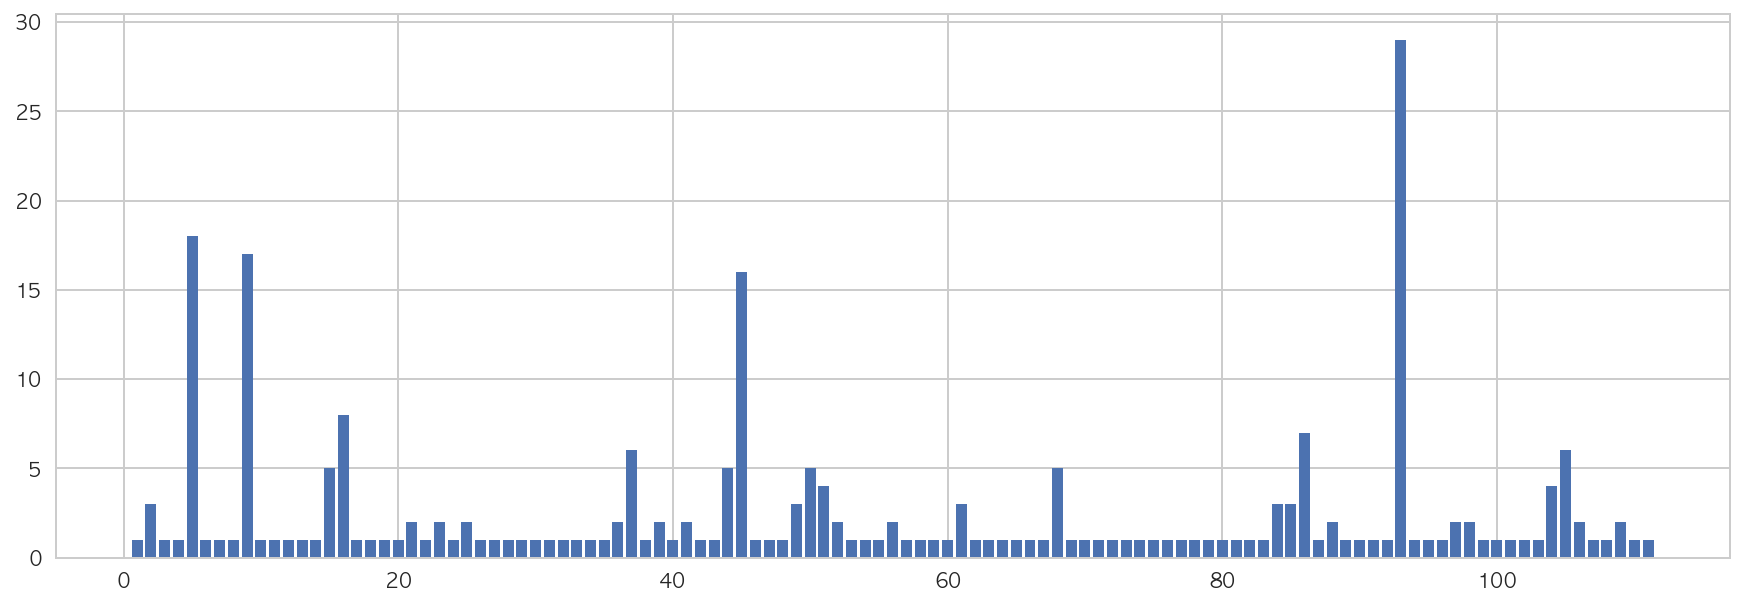

In [14]:
plt.figure(figsize=(15, 5))
plt.bar(x, y)
plt.show()